In [ ]:
# default_exp tabular.interpretation

# tabular.interpretation

> Useful interpretation functions for tabular, such as Feature Importance

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai2.tabular.all import *

In [ ]:
#export
def base_error(err, val): return (err/val)/err

In [ ]:
#export
class PermutationImportance():
    "Calculate and plot the permutation importance"
    def __init__(self, learn:Learner, df=None, metric=accuracy, bs=None, perm_func=base_error, reverse=True):
        "Initialize with a test dataframe, a learner, and a metric"
        self.learn = learn
        self.df = df
        bs = bs if bs is not None else learn.dls.bs
        if self.df is not None:
            self.dl = learn.dls.test_dl(self.df, bs=bs)
        else:
            self.dl = learn.dls[1]
        self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
        self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
        self.y = dls.y_names
        orig_metric = self.learn.metrics[1:]
        self.learn.metrics = [metric]
        self.results = self.calc_feat_importance(perm_func, reverse)
        self.plot_importance(self.ord_dic_to_df(self.results))
        self.learn.metrics = orig_metric

    def measure_col(self, name:str):
        "Measures change after column shuffle"
        col = [name]
        if f'{name}_na' in self.na: col.append(name)
        orig = self.dl.items[col].values
        perm = np.random.permutation(len(orig))
        self.dl.items[col] = self.dl.items[col].values[perm]
        with self.learn.no_bar(), self.learn.no_logging():
            metric = learn.validate(dl=self.dl)[1]
        self.dl.items[col] = orig
        return metric

    def calc_feat_importance(self, perm_func=base_error, reverse=True):
        "Calculates permutation importance by shuffling a column on a percentage scale"
        print('Getting base error')
        with self.learn.no_bar(), self.learn.no_logging():
            base_error = self.learn.validate(dl=self.dl)[1]
        self.importance = {}
        pbar = progress_bar(self.x_names)
        print('Calculating Permutation Importance')
        for col in pbar:
            self.importance[col] = self.measure_col(col)
        for key, value in self.importance.items():
            self.importance[key] = perm_func(base_error, value)
        return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

    def ord_dic_to_df(self, dict:OrderedDict):
        return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

    def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
        "Plot importance with an optional limit to how many variables shown"
        df_copy = df.copy()
        df_copy['feature'] = df_copy['feature'].str.slice(0,25)
        df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
        ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
        for p in ax.patches:
            ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [ ]:
show_doc(PermutationImportance)

<h2 id="PermutationImportance" class="doc_header"><code>class</code> <code>PermutationImportance</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>PermutationImportance</code>(**`learn`**:`Learner`, **`df`**=*`None`*, **`metric`**=*`'accuracy'`*, **`bs`**=*`None`*, **`perm_func`**=*`'base_error'`*, **`reverse`**=*`True`*)

Calculate and plot the permutation importance

We can pass in sections of a `DataFrame`, but not a `DataLoader`. `perm_func` dictates how to calculate our importance, and `reverse` will determine how to sort the output

# Example Usage

We'll run an example on the `ADULT_SAMPLE` dataset

In [ ]:
from fastai2.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

In [ ]:
df = pd.read_csv(path/'adult.csv')
splits = RandomSplitter()(range_of(df))
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.361757,0.358647,0.834152,00:03


Getting base error
Calculating Permutation Importance


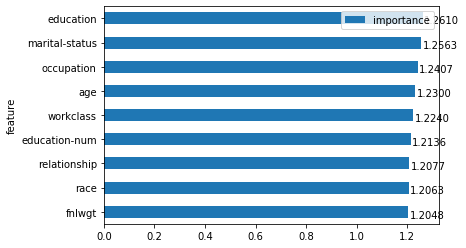

In [ ]:
perm = PermutationImportance(learn, df.iloc[:1000], bs=64)